## Problem 1

In [ ]:
import wrds
import pandas as pd
db=wrds.Connection(wrds_username='harpersss')
from datetime import datetime
#get data
data=db.raw_sql("select  permco, date,ret "
           "from crsp.dsf "
           "where permco in (7,35048,8048,21446,20792) "
           "and date>='1999-12-31'"
            "and date<='2021-12-31'")
data.to_csv('data.csv', sep=';', index=False)
# rename
data = pd.read_csv("data.csv", sep=';')   
data.loc[data.permco ==7,'permco'] = 'AAPL'
data.loc[data.permco ==8048,'permco'] = 'MSFT'
data.loc[data.permco ==35048, 'permco'] = 'GS' 
data.loc[data.permco ==21446, 'permco'] = 'PG' 
data.loc[data.permco ==20792, 'permco'] = 'GE' 
data = data.rename(columns={'permco':'stock'})

In [170]:
#(a)
S_list = ['AAPL','MSFT','GS','PG','GE']
stock_map={}
win_stock_map={}

data_winsorized=data[abs(data['ret']) < 0.04]
for stock in S_list:
    stock_map[stock] = {'mean': data.loc[data.stock ==stock,'ret'].mean()}
    stock_map[stock]['var'] = data.loc[data.stock ==stock,'ret'].var()
    win_stock_map[stock] = {'mean': data_winsorized.loc[data_winsorized.stock ==stock,'ret'].mean()}
    win_stock_map[stock]['var'] = data_winsorized.loc[data_winsorized.stock ==stock,'ret'].var()
    print(stock+' mean: ', '{:05.5f}'.format(stock_map[stock]['mean']),' Var: ', '{:05.5f}'.format(stock_map[stock]['var']))

AAPL mean:  0.00132  Var:  0.00064
MSFT mean:  0.00058  Var:  0.00037
GS mean:  0.00057  Var:  0.00054
PG mean:  0.00040  Var:  0.00018
GE mean:  0.00007  Var:  0.00045


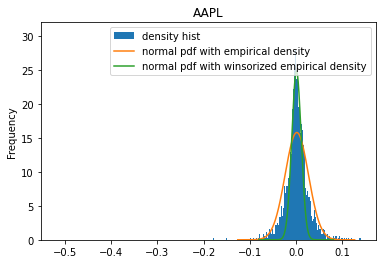

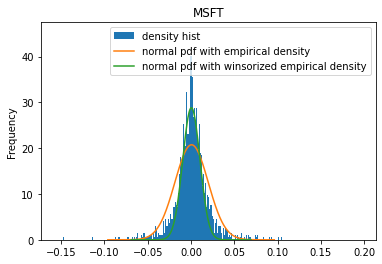

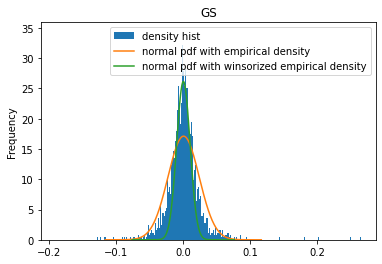

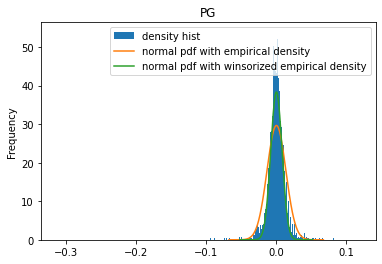

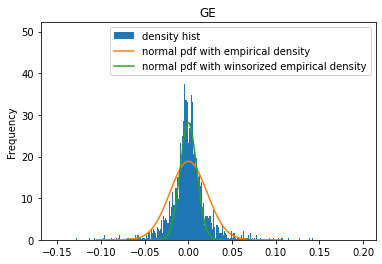

In [171]:
#(b)
import matplotlib.pyplot as plt
import numpy as np

for stock in S_list:
    data.loc[data.stock == stock,'ret'].plot.hist(bins=1000,density=True,label='density hist')
    x=np.linspace(-5*np.sqrt(stock_map[stock]['var']),+5*np.sqrt(stock_map[stock]['var']),500)
    y=np.exp(-0.5*(x-stock_map[stock]['mean'])**2/stock_map[stock]['var'])/np.sqrt(2*np.pi*stock_map[stock]['var'])
    plt.plot(x,y,label='normal pdf with empirical density')
    x_win=np.linspace(-5*np.sqrt(win_stock_map[stock]['var']),+5*np.sqrt(win_stock_map[stock]['var']),500)
    y_win=np.exp(-0.5*(x-win_stock_map[stock]['mean'])**2/win_stock_map[stock]['var'])/np.sqrt(2*np.pi*win_stock_map[stock]['var'])
    plt.plot(x_win,y_win,label='normal pdf with winsorized empirical density')
    plt.title(stock)
    plt.legend()
    plt.show()

In [172]:
#(c)
from scipy.stats import norm

mean_list=[]
var_list=[]
print('Name          95%       99%')
for stock in S_list:
    mean_list.append(stock_map[stock]['mean'])
    var_list.append(stock_map[stock]['var'])
    print(stock+' Empirical: ','{:.2%}'.format((pd.DataFrame(data.loc[data.stock == stock,'ret'])['ret'].quantile(0.05))),'  ', '{:.2%}'.format((pd.DataFrame(data.loc[data.stock == stock,'ret'])['ret'].quantile(0.01))))
    print(stock+' Normal   : ','{:.2%}'.format(norm.ppf(0.05, stock_map[stock]['mean'],np.sqrt(stock_map[stock]['var']))),'    ','{:.2%}'.format(norm.ppf(0.01, stock_map[stock]['mean'], np.sqrt(stock_map[stock]['var']))))

# combine 95% ret, 99% ret with real daily ret data
data1=data.set_index(['date','stock'])
q95_ret_real=data1.groupby('stock')['ret'].quantile(0.05)
q99_ret_real=data1.groupby('stock')['ret'].quantile(0.01)
data2=pd.merge(data1,q95_ret_real, how='left', on='stock')
data2=data2.rename(columns={"ret_y": "q95_ret_real"})
data2=pd.merge(data2,q99_ret_real, how='left', on='stock')
data2=data2.rename(columns={"ret": "q99_ret_real","ret_x": "ret"})
#calculate 95%,99% real ret data mean
q95_data_ret_mean=data2[data2['ret']<data2['q95_ret_real']].groupby('stock')['ret'].mean()
q99_data_ret_mean=data2[data2['ret']<data2['q99_ret_real']].groupby('stock')['ret'].mean()

#calculate normal distribution data
q95_normal=pd.Series(mean_list, index=S_list)-np.sqrt(pd.Series(var_list, index=S_list))*norm.pdf(norm.ppf(0.05,0,1))/norm.cdf(norm.ppf(0.05,0,1))
q99_normal=pd.Series(mean_list, index=S_list)-np.sqrt(pd.Series(var_list, index=S_list))*norm.pdf(norm.ppf(0.01,0,1))/norm.cdf(norm.ppf(0.01,0,1))

result_table = pd.DataFrame({ '95% Empirical' : q95_data_ret_mean, 
                    '99% Empirical' : q99_data_ret_mean,
                    '95% Normal' : q95_normal, 
                    '99% Normal' : q99_normal 
                      })
print('\n empirical & normal, 95% & 99% Expected Shortfall')
display(result_table.style.format("{:.2%}"))

Name          95%       99%
AAPL Empirical:  -3.68%    -6.40%
AAPL Normal   :  -4.02%      -5.74%
MSFT Empirical:  -2.83%    -5.43%
MSFT Normal   :  -3.11%      -4.42%
GS Empirical:  -3.35%    -6.25%
GS Normal   :  -3.78%      -5.37%
PG Empirical:  -1.75%    -3.54%
PG Normal   :  -2.17%      -3.09%
GE Empirical:  -3.13%    -6.05%
GE Normal   :  -3.47%      -4.91%

 empirical & normal, 95% & 99% Expected Shortfall


,95% Empirical,99% Empirical,95% Normal,99% Normal
AAPL,-5.62%,-9.34%,-5.08%,-6.60%
GE,-4.98%,-8.34%,-4.35%,-5.63%
GS,-5.20%,-9.06%,-4.75%,-6.16%
MSFT,-4.44%,-7.56%,-3.91%,-5.07%
PG,-3.12%,-5.78%,-2.74%,-3.55%


### (d)
From the result we get above, we can say that normal distribution can't describe distribution of daily stock returns appropriately.

(a) The graphs we draw above illustrate that daily stock return and normal distribution are quite similar in the distribution center, but normal distribution seems has higher variance (more disperse) than real distribution. This can also be verified that if we use winsorized mean and variance, winsorized normal distribution can better fit real distribution in the center. (But it will underfit on the edge.)

(b) Moreover, normal distribution will also underfit extreme situation, which means it underfits the risk. Actually in real life, "Black swan" incidents always happen, indicating small probability will occur way more frequently than its probability. This stands consistent with daily stock returns. In real daily stock returns, 95% and 99% expected shortfall is much larger than normal distribution. 

Therefore, if we use normal distribution, we will underestimate market risk, which is dangerous.




In [173]:
#(e)
bonds_y2=db.raw_sql("select  caldt, b2ret  "
           "from crsp.mcti "           
            "where caldt>='1999-12-31'"
            "and caldt<='2021-12-31'", date_cols=['caldt'])
bonds_y2=bonds_y2.rename(columns={ "caldt": "date"})
bonds_y10=db.raw_sql("select  caldt, b10ret  "
           "from crsp.mcti "           
            "where caldt>='1999-12-31'"
            "and caldt<='2021-12-31'", date_cols=['caldt'])
bonds_y10=bonds_y10.rename(columns={ "caldt": "date"})

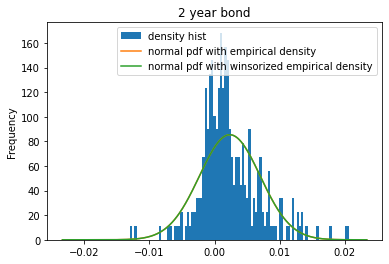

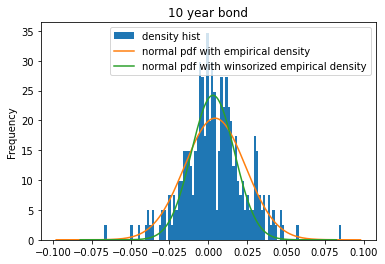

Name                 95%       99%
2 year bond True  :  -0.37%    -0.75%
2 year bond Normal:  -0.53%      -0.85%
10 year bond True  :  -2.70%    -4.22%
10 year bond Normal:  -2.79%      -4.12%


In [174]:
# 2 year bond
bonds_y2_win=bonds_y2[abs(bonds_y2['b2ret']) < 0.04]
var_y2 = np.var(bonds_y2['b2ret'])
mean_y2 = np.mean(bonds_y2['b2ret'])
var_y2_win = np.var(bonds_y2_win['b2ret'])
mean_y2_win = np.mean(bonds_y2_win['b2ret'])
bonds_y2['b2ret'].plot.hist(bins=100,density=True,label='density hist')
x=np.linspace(-5*np.sqrt(var_y2),+5*np.sqrt(var_y2),500)
y=np.exp(-0.5*(x-mean_y2)**2/var_y2)/np.sqrt(2*np.pi*var_y2)
plt.plot(x,y,label='normal pdf with empirical density')
x_win=np.linspace(-5*np.sqrt(var_y2_win),+5*np.sqrt(var_y2_win),500)
y_win=np.exp(-0.5*(x-mean_y2_win)**2/var_y2_win)/np.sqrt(2*np.pi*var_y2_win)
plt.plot(x_win,y_win,label='normal pdf with winsorized empirical density')
plt.title('2 year bond')
plt.legend()
plt.show()
# 10 year bond
bonds_y10_win=bonds_y10[abs(bonds_y10['b10ret']) < 0.04]
var_y10 = np.var(bonds_y10['b10ret'])
mean_y10 = np.mean(bonds_y10['b10ret'])
var_y10_win = np.var(bonds_y10_win['b10ret'])
mean_y10_win = np.mean(bonds_y10_win['b10ret'])
bonds_y10['b10ret'].plot.hist(bins=100,density=True,label='density hist')
x=np.linspace(-5*np.sqrt(var_y10),+5*np.sqrt(var_y10),500)
y=np.exp(-0.5*(x-mean_y10)**2/var_y10)/np.sqrt(2*np.pi*var_y10)
plt.plot(x,y,label='normal pdf with empirical density')
x_win=np.linspace(-5*np.sqrt(var_y10_win),+5*np.sqrt(var_y10_win),500)
y_win=np.exp(-0.5*(x-mean_y10_win)**2/var_y10_win)/np.sqrt(2*np.pi*var_y10_win)
plt.plot(x_win,y_win,label='normal pdf with winsorized empirical density')
plt.title('10 year bond')
plt.legend()
plt.show()

# quantile
print('Name                 95%       99%')
print('2 year bond True  : ','{:.2%}'.format(bonds_y2['b2ret'].quantile(0.05)),'  ', '{:.2%}'.format(bonds_y2['b2ret'].quantile(0.01)))
print('2 year bond Normal: ','{:.2%}'.format(norm.ppf(0.05, mean_y2,np.sqrt(var_y2))),'    ','{:.2%}'.format(norm.ppf(0.01, mean_y2, np.sqrt(var_y2))))
print('10 year bond True  : ','{:.2%}'.format(bonds_y10['b10ret'].quantile(0.05)),'  ', '{:.2%}'.format(bonds_y10['b10ret'].quantile(0.01)))
print('10 year bond Normal: ','{:.2%}'.format(norm.ppf(0.05, mean_y10,np.sqrt(var_y10))),'    ','{:.2%}'.format(norm.ppf(0.01, mean_y10, np.sqrt(var_y10))))

From the graphs and datas, we get to know that normal distribution also can't fit bond returns well.

(a) Bonds return tend to have small variance than stocks especially in short maturity. 

(b) Winsorized and unwinsorized normal distributions are almost the same in short maturity bond.

(c) Bonds with long maturity fits normal distribution better than bonds with short maturity.

## Problem 2

In [3]:
import wrds
db=wrds.Connection(wrds_username='hlanfran')

Loading library list...
Done


In [4]:
data=db.raw_sql("select  permco, date,ret "
           "from crsp.dsf "
           "where permco in (7,21446) "
           "and date>='2010-01-01'"
            "and date<='2021-12-31'"
            )
data.to_csv('data.csv', sep=';', index=False)
# rename
data = pd.read_csv("data.csv", sep=';')   
data.loc[data.permco ==7,'permco'] = 'AAPL'
data.loc[data.permco ==21446, 'permco'] = 'PG' 
data = data.rename(columns={'permco':'stock'})

In [5]:
data_aapl = data[data.stock == "AAPL"].set_index("date")
data_aapl.index = pd.to_datetime(data_aapl.index)
data_aapl = data_aapl.rename(columns={"ret":"ret_aapl"})
data_aapl.ret_aapl = data_aapl.ret_aapl + 1
data_aapl = data_aapl.resample('W').prod() - 1

In [6]:
data_pg = data[data.stock == "PG"].set_index("date")
data_pg.index = pd.to_datetime(data_pg.index)
data_pg = data_pg.rename(columns={"ret":"ret_pg"})
data_pg.ret_pg = data_pg.ret_pg + 1 
data_pg = data_pg.resample('W').prod() - 1

In [7]:
data_m = pd.concat([data_aapl,data_pg],axis=1)

In [8]:
#(a)
import numpy as np
mean_aapl = data_m.ret_aapl.mean()*52
std_aapl = data_m.ret_aapl.std()*np.sqrt(52)

mean_pg = data_m.ret_pg.mean()*52
std_pg = data_m.ret_pg.std()*np.sqrt(52)

corr = data_m.ret_aapl.corr(data_m.ret_pg)

print(f"The expected return for apple is {mean_aapl*100}% and for pg is {mean_pg*100}%, the expected stand deviation for apple is {std_aapl*100}% and for pg is {std_pg*100}%")
print(f"The correlation between the two stocks is {corr}")

The expected return for apple is 31.48879935246491% and for pg is 12.49407994953264%, the expected stand deviation for apple is 27.88550976111967% and for pg is 15.54840949314871%
The correlation between the two stocks is 0.31587164916767546


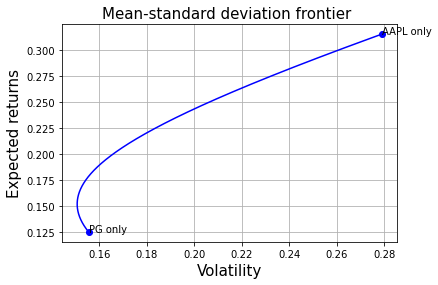

In [25]:
#(b)
import matplotlib.pyplot as plt

weights = np.linspace(start=0, stop=1.0, num=1000)
returns = weights*mean_aapl+(1-weights)*mean_pg
std_return = np.sqrt(weights**2*std_aapl**2+(1-weights)**2*std_pg**2+2*corr*std_aapl*std_pg*weights*(1-weights))


plt.plot(std_return, returns, linestyle='-', c='blue')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Expected returns', fontsize=15)
plt.title('Mean-standard deviation frontier ', fontsize=15)
plt.grid(True)

plt.annotate('AAPL only', (std_return[-1], returns[-1]))
plt.annotate('PG only', (std_return[0], returns[0]))
plt.plot([std_return[-1],std_return[0]], [returns[-1],returns[0]], 'bo')

In [17]:
#(c)
risk_free = 0.015
min_std = np.argmin(std_return)

print(f' AAPL Weight: {weights[min_std]}')
print(f' PG Weight: {(1-weights[min_std])}')
print(f' Portfolio mean: {returns[min_std]*100}%')
print(f' Portfolio std: {std_return[min_std]*100}%')
print(f' Sharp Ratio: {(returns[min_std]-risk_free)/std_return[min_std]}')

 AAPL Weight: 0.14014014014014015
 PG Weight: 0.8598598598598599
 Portfolio mean: 15.156002588582208%
 Portfolio std: 15.067182599853341%
 Sharp Ratio: 0.9063408170758566


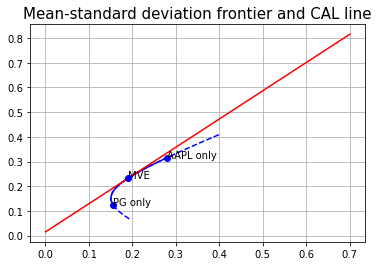

In [26]:
#(d)
sharp_ratio = (returns - risk_free)/std_return
best_sharp_ratio = sharp_ratio.max()
x= np.linspace(start=0, stop=0.7, num=1000)
cal_line = risk_free + best_sharp_ratio*x

weights_extended = np.linspace(start=-0.3, stop=1.5, num=1000)
returns_extended = weights_extended*mean_aapl+(1-weights_extended)*mean_pg
std_return_extended = np.sqrt(weights_extended**2*std_aapl**2+(1-weights_extended)**2*std_pg**2+2*corr*std_aapl*std_pg*weights_extended*(1-weights_extended))


plt.plot(std_return, returns, linestyle='-', c='blue')
plt.plot(std_return_extended, returns_extended, linestyle='--', c='blue')
plt.plot(x,cal_line,linestyle='-', c='red')
plt.title('Mean-standard deviation frontier and CAL line', fontsize=15)
plt.grid(True)


plt.annotate('AAPL only', (std_return[-1], returns[-1]))
plt.annotate('PG only', (std_return[0], returns[0]))
plt.annotate('MVE', (std_return[np.argmax(sharp_ratio)], returns[np.argmax(sharp_ratio)]))
plt.plot([std_return[-1],std_return[0],std_return[np.argmax(sharp_ratio)]], [returns[-1],returns[0],returns[np.argmax(sharp_ratio)]], 'bo')


In [19]:
#(e)
#(mean_p - R0)*volatility_a/(mean_a-R0) = (volatility_a)
optimal_result_volatility = (0.5-risk_free)*std_return[np.argmax(sharp_ratio)]/(returns[np.argmax(sharp_ratio)] - risk_free)
weight_volatility = optimal_result_volatility/std_return[np.argmax(sharp_ratio)]

free_risk_weight = 1 - weight_volatility
apple_weight = weight_volatility * weights[np.argmax(sharp_ratio)]
pg_weight = weight_volatility * (1-weights[np.argmax(sharp_ratio)])
print(f"The weight for the risk free asset is {free_risk_weight}")
print(f"The weight for apple is {apple_weight}")
print(f"The weight for PG is {pg_weight}")

The weight for the risk free asset is -1.2351454383335345
The weight for apple is 1.25964652831009
The weight for PG is 0.9754989100234446


In [20]:
#(f)
#from the equation mean_i-R0 = aCov(Ri,Rp) for every i
a = (returns[np.argmax(sharp_ratio)]-risk_free)/(apple_weight**2*std_aapl**2+pg_weight**2*std_pg**2+pg_weight*std_pg*apple_weight*std_aapl*corr)
print(f"The risk aversion coefficient is {a}")

The risk aversion coefficient is 1.3294483197718376


In [21]:
#(g)
#The sharp ratio is the same because our new portofolio is on the CAL line
print(f"The sharp ratio is {best_sharp_ratio}")
print(f"The volatility of the portofolio is {optimal_result_volatility}% which is {optimal_result_volatility*10000000}$")

The sharp ratio is 1.1430119313931482
The volatility of the portofolio is 0.42431753044682813% which is 4243175.304468282$
